In [41]:
import pandas as pd
import numpy as np
import zipfile
import tensorflow as tf
from keras.models import Sequential
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
germanTrafic = "/content/drive/MyDrive/german-trafic-sign.zip"
germanTraficRef = zipfile.ZipFile(germanTrafic, 'r')
germanTraficRef.extractall('/content')
germanTraficRef.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/drive/MyDrive/german-trafic-sign.zip' mode='r'>>

In [44]:
## Load data
training_file = "/content/train.p"
testing_file = "/content/test.p"

In [45]:
# Buka dan meload training file
with open(training_file, mode='rb') as f:
  train = pickle.load(f)

# Buka dan meload testing file
with open(testing_file, mode='rb') as f:
  test = pickle.load(f)

print('Data Loaded')

Data Loaded


In [46]:
# membuat pandas dataframe untuk load csv
# Isi file csv adalah ClassId dan SignName
sign_name_df = pd.read_csv('/content/signnames.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


In [47]:
# Tentukan fitur dan label untuk data pelatihan
x, y = train['features'], train['labels']

# Mengubah daftar menjadi array numpy
data = np.array(x)
labels = np.array(y)
print(data.shape, labels.shape)

(34799, 32, 32, 3) (34799,)


In [48]:
# Tentukan fitur dan label untuk data pengujian
x_test, y_test = test['features'], test['labels']

# Converting lists into numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)
print(x_test.shape, y_test.shape)

(12630, 32, 32, 3) (12630,)


In [49]:
# Split training data ke train dan val
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=0)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


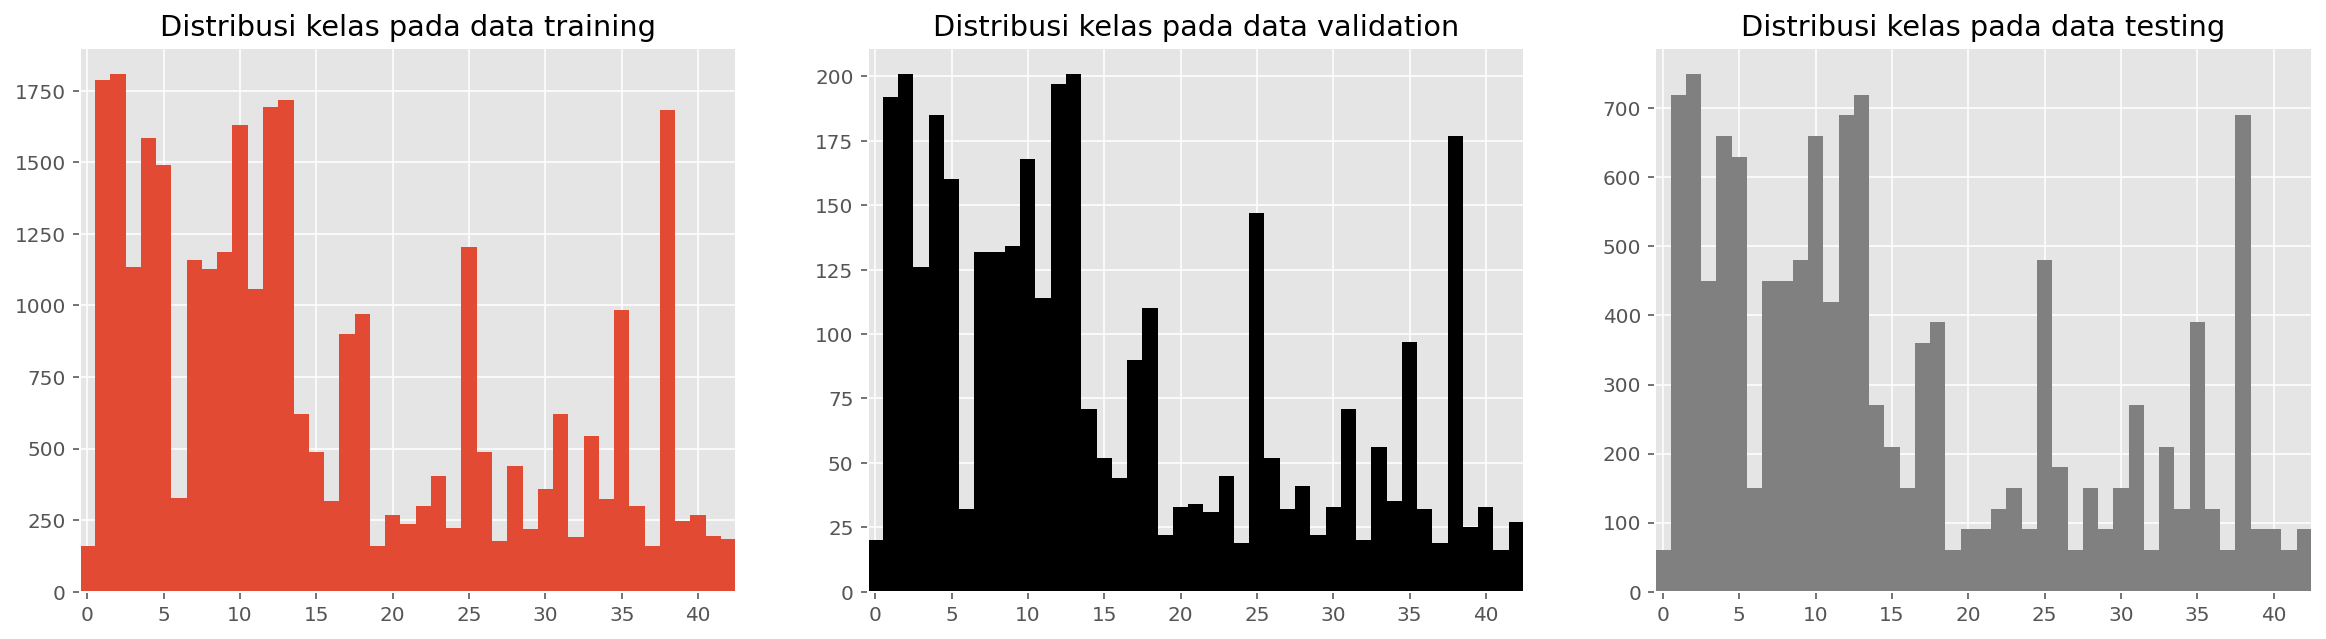

In [50]:
n_labels = np.unique(y_train).size
def hist_data(y_data, title=None, ax=None, **kwargs):
  if not ax:
    fig=plt.figure()
    ax=fig.add_subplot(111)
  ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
  ax.set_xlim(-0.5, n_labels-0.5)
  if 'label' in kwargs : ax.legend()
  if title : ax.set_title(title)

fig,ax = plt.subplots(1,3, figsize=(20,5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validation', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data testing', ax=ax[2], color='grey')

In [51]:
# Mengubah label menjadi one hot encoding
from tensorflow.keras.utils import to_categorical
 
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

In [52]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96):
      print('\n Akurasi telah mencapai lebih dari 96%. Train diberhentikan!')
      self.model.stop_training = True
callback = myCallback()

In [53]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

In [54]:
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [55]:
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

In [56]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 32)        25632     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 64)         

In [57]:
# Compile the modeul
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 25
history = model.fit(x_train, y_train, batch_size=32, epochs=epochs, validation_data=(x_val, y_val), callbacks=[callback])
model.save("my_model.h5")

Epoch 1/25
979/979 [==============================] - 10s 10ms/step - loss: 2.0247 - accuracy: 0.4661 - val_loss: 0.6221 - val_accuracy: 0.8466
Epoch 2/25
979/979 [==============================] - 9s 9ms/step - loss: 0.8480 - accuracy: 0.7411 - val_loss: 0.4004 - val_accuracy: 0.9000
Epoch 3/25
979/979 [==============================] - 9s 9ms/step - loss: 0.6155 - accuracy: 0.8121 - val_loss: 0.2632 - val_accuracy: 0.9365
Epoch 4/25
979/979 [==============================] - 9s 9ms/step - loss: 0.4617 - accuracy: 0.8591 - val_loss: 0.1789 - val_accuracy: 0.9471
Epoch 5/25
979/979 [==============================] - 9s 9ms/step - loss: 0.3815 - accuracy: 0.8863 - val_loss: 0.1502 - val_accuracy: 0.9606
Epoch 6/25
979/979 [==============================] - 9s 9ms/step - loss: 0.3482 - accuracy: 0.8949 - val_loss: 0.1074 - val_accuracy: 0.9741
Epoch 7/25
979/979 [==============================] - 9s 9ms/step - loss: 0.3172 - accuracy: 0.9045 - val_loss: 0.0834 - val_accuracy: 0.9782
Epoc

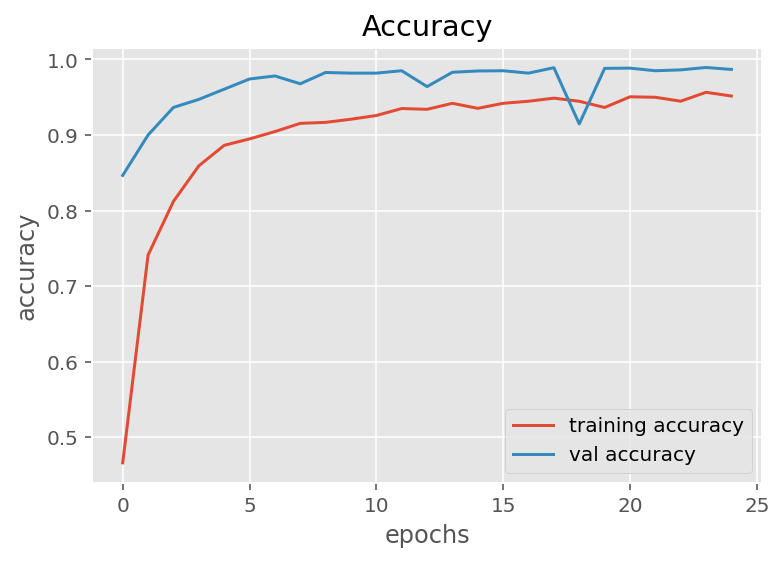

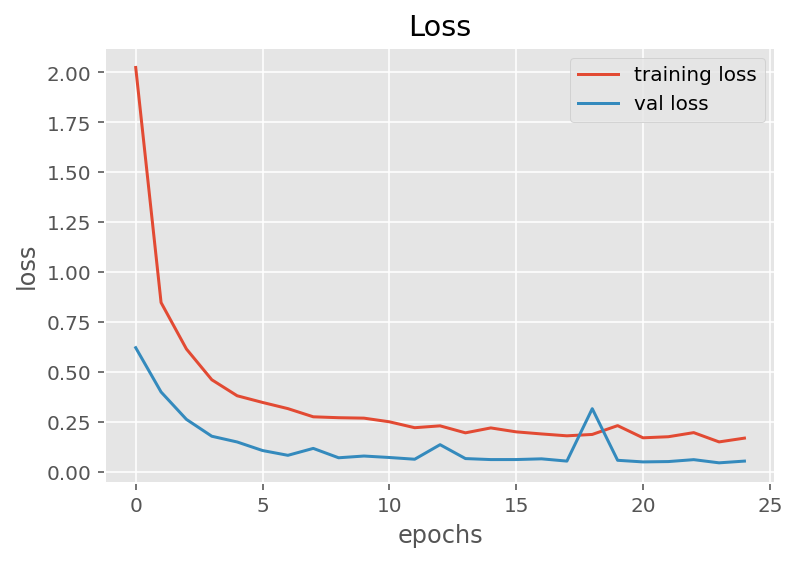

In [58]:
# Plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
 
# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [59]:
# Testing accuracy with the test data
from sklearn.metrics import accuracy_score
 
pred=np.argmax(model.predict(x_test), axis=-1)
accuracy_score(y_test, pred)

0.9444972288202692

In [60]:
# Calculate metrics for classification
from sklearn.metrics import classification_report
 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        60
           1       0.93      0.97      0.95       720
           2       0.95      0.97      0.96       750
           3       0.97      0.93      0.95       450
           4       0.98      0.97      0.97       660
           5       0.91      0.94      0.93       630
           6       0.99      0.81      0.89       150
           7       0.94      0.95      0.95       450
           8       0.91      0.96      0.93       450
           9       0.96      1.00      0.98       480
          10       0.99      0.99      0.99       660
          11       0.87      0.91      0.89       420
          12       0.98      0.95      0.97       690
          13       0.98      1.00      0.99       720
          14       0.99      0.99      0.99       270
          15       0.89      0.99      0.94       210
          16       1.00      0.99      1.00       150
          17       0.99    